In [1]:
import sys
sys.path.append("../../")

from astronn.datasets import deltascuti
from astronn import models

import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt

from alibi.explainers import CounterFactual
from alibi.explainers import CounterFactualProto

Using TensorFlow backend.


#### Load eleven delta scuti stars

In [2]:
# Read datasets of preprocessed stars
df_ds = deltascuti()
df = df_ds.load("../../astronn/data/deltascuti/preprocessed/*", batch_size=1)

stars = None
target_class = None

for star in df.take(1):
    print("DS star ID: ", star[0])
    target_class = np.where(star[2].numpy().flat == 1)[0].flat[0]
    print("Target class:", target_class)
    star = star[1].numpy()
print(star.shape)


DS star ID:  tf.Tensor([b'KIC9851944'], shape=(1,), dtype=string)
Target class: 26
(1, 406, 3)


### Load model saved from disk (whit TF eager deisabled)

In [3]:
tf.compat.v1.disable_eager_execution()
sepconv_mod = tf.keras.models.load_model("/tmp/sepconvnn_tmp_400")
sepconv_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv1d (SeparableC (None, 397, 10)           610       
_________________________________________________________________
batch_normalization (BatchNo (None, 397, 10)           40        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 198, 10)           0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 194, 10)           1510      
_________________________________________________________________
batch_normalization_1 (Batch (None, 194, 10)           40        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 97, 10)            0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 93, 10)            1

### Create a contrafactual prototype. 

- $\kappa$ : difference between the predicted probabilities for the perturbed instance of the original class and the max of the other classes. Must be increased in our case
- feature_range: Max and min values for perturbed instance. Is set up to [-0.2,1] allowing some negative values and all positive range values

In [4]:
cf = CounterFactualProto(
    sepconv_mod, kappa=0.01, feature_range=(-0.2, 1), shape=(1, 406, 3)
)
explanation = cf.explain(
    star, k=1, target_class=[i for i in range(55, 65)], verbose=False
)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


## Show original and closest contrafactual example

Counterfactual prediction: 55


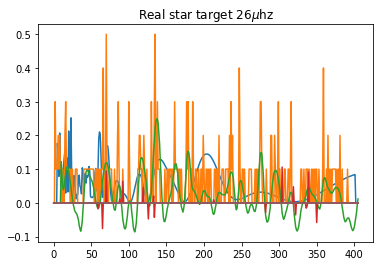

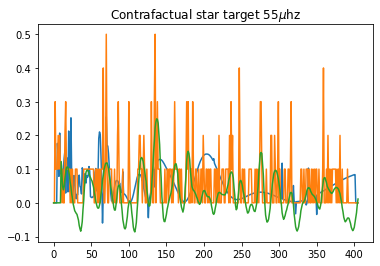

In [6]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
exp_data = explanation.cf['X']

plt.plot(star[0, :, 0])
plt.plot(star[0, :, 1])
plt.plot(star[0, :, 2])
plt.title(r'Real star target %s%s'% (target_class, r'$\mu$hz'))

plt.plot(exp_data[0, :, 0] - star[0, :, 0])
plt.plot(exp_data[0, :, 1] - star[0, :, 1])
plt.plot(exp_data[0, :, 2] - star[0, :, 2])
plt.show()

plt.plot(exp_data[0, :, 0])
plt.plot(exp_data[0, :, 1])
plt.plot(exp_data[0, :, 2])
plt.title(r'Contrafactual star target %s%s'% (explanation.cf['class'], r'$\mu$hz'))
plt.show()